<a href="https://colab.research.google.com/github/vanderbilt-ml/51-prybol-mlproj-xclass/blob/main/project_description.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proposed Project

##Background
I work as a data science executive for a healthcare technology company that offers predictive analytics, data augumentation, and warehousing for health insurance companies, provider networks, health systems, and large employer groups. As part of our offerings we have developed a robust set of validations that allow us to standardize and normalize data at massive scales. Most of these validations however, are rules and/or statistics based and their development requires significant effort from subject matter experts. With the long term goal of scaling beyond the limits of constrained resoures (SME effort) we have been seeking machine learning drive approachs that would allow us to algorithmically identify potential anomalies without a priori knowledge of what those anomalies may be. One potential validation would be to predict which diagnosis codes should appear on a medical claim based on the billed procedure codes and flag anomalous claims where the diagnosis codes do not match expectations. 


## Project Description
Predicting diagnosis codes from procedure codes appears to be a straightfoward proposition, but the processs is deceivingy complex. With the switch to ICD-10, there are now more than 70,000 unique procedure codes or "tokens". This number grows even larger with the inclusion of the Current Procedural Terminology (CPT) code set (10,471 unqiue CPT codes). For reference, this combined vocabulary is nearly three times larger than the vocabularly used in Google's seminal natural language processing paper on BERT (Bidirectional Encoder Representations from Transformers). Each healthcare encounter can result in any number of unique procedure codes being billed. While the number of codes billed in a single claim or encounter is technically unlimited, a typical range is anywhere from 1 to 25. Given the large vocabulary and the variable length of codes billed to a single encounter, one common way to handle these complexities is by treating medical codes as "words" in a "sentence" or "document". 

Addtionally, the model target, in this case the complete set of ICD diagnosis codes, contains more than 69,000 unique values. While some of these tokens are are quite common, others are exceedingly rare. Any loss function used during model training need to take into account the relative prevalences of these codes. It stands to reason that the more rare the code in the target set, the more imporant it may be to any anomaly detection engine. 

Extreme multi-label classification (XMC) is the problem of finding the relevant labels for an input, from a very large universe of possible labels. XMC is a natural fit for this project given the scope of the target. As a result, this project will borrow heavily from the fields of natural language processing and XMC.  

To date, no administrative claims data has been made publically available for research purposes. For this project I will leverage my existing access to the [MIMIC-IV (Medical Information Mart for Intensive Care)](https://mimic.mit.edu) research database that contains the data from over 500,000 intensive care stays. This database has been augmented to include the billed procedure and diagnosis codes. While the total subset of unique codes will be limited by the types of nature of the dataset (limited to ICU stays), the overall scope should be representitive of the larger scale problem. 

# Performance Metrics
Peformance will be measured using metrics that have been widely adopted for XML and ranking tasks. Precision at $k$ (p$@k$) is one such metric that counts the fraction of correct predictions in the top $k$ scoring labels in $\hat{y}$, and has been widely utilized. The ranking measure Normalized (Discounted) Cumlative Gain at $k$ (nDCG$@k$) as another evaluation metric. The p$@k$ and nDCG$@k$ metrics are defined for a predicted score vector $\hat{\mathbf y} \in {\mathbb{R}}^{L}$ and ground truth label vector $\mathbf y \in \left\lbrace 0, 1 \right\rbrace^L$ as: 

\begin{align}
        \text{P}@k := \frac{1}{k} \sum_{l\in \text{rank}_k (\hat{\mathbf y})} \mathbf y_l\\[1em]
        \text{DCG}@k := \sum_{l\in {\text{rank}}_k (\hat{\mathbf y})} \frac{\mathbf y_l}{\log(l+1)}\\[1em]
        \text{nDCG}@k := \frac{{\text{DCG}}@k}{\sum_{l=1}^{\min(k, \|\mathbf y\|_0)} \frac{1}{\log(l+1)}},\\[1em]
    \end{align}

where, $\text{rank}_k(\mathbf y)$ returns the $k$ largest indices of $\mathbf{y}$ ranked in descending order.

For datasets that contain excessively popular labels (often referred to as "head" labels) such as diagnosis codes, high p$@k$ may be achieved by simply predicting head labels repeatedly irrespective of their relevance to the data point. To check for such trivial behavior, it is recommended that XC methods also be evaluated with respect to propensity-scored counterparts of the p$@k$ and nDCG$@k$ metrics (PSP$@k$ and PSnDCG$@k$) described below.

\begin{align}
        \text{PSP}@k := \frac{1}{k} \sum_{l\in \text{rank}_k (\hat{\mathbf y})} \frac{\mathbf y_l}{p_l}\\[1em]
        \text{PSDCG}@k := \sum_{l\in {\text{rank}}_k (\hat{\mathbf y})} \frac{\mathbf y_l}{p_l\log(l+1)}\\[1em]
        \text{PSnDCG}@k := \frac{{\text{PSDCG}}@k}{\sum_{l=1}^{k} \frac{1}{\log(l+1)}},\\[1em]
    \end{align}

where $p_l$ is the propensity score for label $l$ which helps in making metrics unbiased with respect to missing labels. Propensity-scored metrics place specific emphasis on performing well on tail labels and give reduced rewards for predicting popular or head labels. For this study we will use metrics$@k$ in $\{1,3,5\}$.

Given that as of the time of writing, no relevant papers on this topic exist, the overarching purpose of this project will be to estabish a benchmark from which future work can be compared against. 

# Data Ingestion and Cleaning

In [64]:
!wget -r -N -c -np --user kprybol --ask-password https://physionet.org/files/mimiciv/1.0/core/patients.csv.gz
!wget -r -N -c -np --user kprybol --ask-password https://physionet.org/files/mimiciv/1.0/core/admissions.csv.gz
!wget -r -N -c -np --user kprybol --ask-password https://physionet.org/files/mimiciv/1.0/hosp/procedures_icd.csv.gz
!wget -r -N -c -np --user kprybol --ask-password https://physionet.org/files/mimiciv/1.0/hosp/diagnoses_icd.csv.gz
!wget -r -N -c -np --user kprybol --ask-password https://physionet.org/files/mimiciv/1.0/hosp/drgcodes.csv.gz
!wget -r -N -c -np --user kprybol --ask-password https://physionet.org/files/mimiciv/1.0/hosp/hcpcsevents.csv.gz

Password for user ‘kprybol’: 
--2022-05-30 03:08:33--  https://physionet.org/files/mimiciv/1.0/core/patients.csv.gz
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 401 Unauthorized
Authentication selected: Basic realm="PhysioNet", charset="UTF-8"
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 304 Not Modified
File ‘physionet.org/files/mimiciv/1.0/core/patients.csv.gz’ not modified on server. Omitting download.

Password for user ‘kprybol’: 
--2022-05-30 03:08:36--  https://physionet.org/files/mimiciv/1.0/core/admissions.csv.gz
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 401 Unauthorized
Authentication selected: Basic realm="PhysioNet", charset="UTF-8"
Reusing existing connection to physionet.org:443.

In [142]:
import pandas as pd
import tensorflow as tf
import numpy as np
import random
import seaborn as sns

In [143]:
pat_df = pd.read_csv('physionet.org/files/mimiciv/1.0/core/patients.csv.gz')
admit_df = pd.read_csv('physionet.org/files/mimiciv/1.0/core/admissions.csv.gz')
proc_df = pd.read_csv('physionet.org/files/mimiciv/1.0/hosp/procedures_icd.csv.gz')
diag_df = pd.read_csv('physionet.org/files/mimiciv/1.0/hosp/diagnoses_icd.csv.gz')
drg_df = pd.read_csv('physionet.org/files/mimiciv/1.0/hosp/drgcodes.csv.gz')
hcpcs_df = pd.read_csv('physionet.org/files/mimiciv/1.0/hosp/hcpcsevents.csv.gz')

In [144]:
proc_gem = pd.read_csv('https://data.nber.org/gem/icd9toicd10pcsgem.csv')
diag_gem = pd.read_csv('https://data.nber.org/gem/icd9toicd10cmgem.csv')

In [145]:
def convert_gem_icd10(df, gem):
  df['icd_code'] = df['icd_code'].astype(str)
  gem['icd9cm'] = gem['icd9cm'].astype(str)
  gem = gem[(gem['combination'] == 1) & (gem['choice_list'] == 1) | (gem['combination'] == 0)]
  print('merging dataframes')
  df_comb = df.merge(gem, how='left', left_on='icd_code', right_on='icd9cm')
  print('recoding to ICD10')
  df_comb['icd_10_recode'] = np.where(df_comb['icd_version'] == 9, df_comb['icd10cm'], df_comb['icd_code'])
  print('filtering dataframe')
  df_comb = df_comb[df_comb['no_map'] != 0]
  df_comb = df_comb[df_comb['icd_10_recode'] != 'NoPCS']
  return df_comb 

In [146]:
diag10_df = convert_gem_icd10(diag_df, diag_gem)
proc10_df = convert_gem_icd10(proc_df, proc_gem)

merging dataframes
recoding to ICD10
filtering dataframe
merging dataframes
recoding to ICD10
filtering dataframe


In [ ]:
pat_df = pat_df.merge(admit_df[['subject_id', 'hadm_id', 'admittime']], how='inner', on=['subject_id'])

In [148]:
import datetime as dt

def convert_anchor_year(x):
  return dt.datetime.combine(dt.date(x, 1, 1), dt.time(0, 0))


pat_df['anchor_dt'] = pat_df['anchor_year'].apply(convert_anchor_year)
pat_df['admittime'] = pd.to_datetime(pat_df['admittime'])
pat_df['age'] = pd.DatetimeIndex(pat_df['admittime']).year - pd.DatetimeIndex(pat_df['anchor_dt']).year + pat_df['anchor_age']
pat_df.head()

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod,hadm_id,admittime,anchor_dt,age
0,10002723,F,0,2128,2017 - 2019,NaN,26724970,2128-06-10 15:29:00,2128-01-01,0
1,10002723,F,0,2128,2017 - 2019,NaN,20429365,2128-06-13 14:15:00,2128-01-01,0
2,10003939,M,0,2184,2008 - 2010,NaN,22561709,2184-06-26 17:48:00,2184-01-01,0
3,10004222,M,0,2161,2014 - 2016,NaN,22106441,2161-05-29 21:09:00,2161-01-01,0
4,10005325,F,0,2154,2011 - 2013,NaN,20047480,2154-12-15 14:10:00,2154-01-01,0


# Basic EDA

In [149]:
# distinct number of ICD procedure and diagnosis codes
print(f'Total number of unique ICD10 Procedure Codes: {proc10_df.icd_10_recode.unique().shape[0]}')
print(f'Total number of unique ICD10 Diagnosis Codes: {diag10_df.icd_10_recode.unique().shape[0]}')
print(f'Total number of unique HCPCS Procedure Codes: {hcpcs_df.hcpcs_cd.unique().shape[0]}')

Total number of unique ICD10 Procedure Codes: 10430
Total number of unique ICD10 Diagnosis Codes: 17628
Total number of unique HCPCS Procedure Codes: 2239


In [150]:
# limit to codes with 5 or more occurances 
proc_10_slim = proc10_df.groupby('icd_10_recode').filter(lambda x: len(x) >= 5)
print(f'Total number of unique ICD10 Procedure Codes kept after frequency filter (n >= 5): {proc_10_slim["icd_10_recode"].unique().shape[0]}')

proc_kept = round((proc_10_slim["icd_10_recode"].unique().shape[0] / proc10_df.icd_10_recode.unique().shape[0])  * 100, 2)
print(f'Total number of ICD10 Procedure Codes included reduced by {proc_kept}%')

diag_10_slim = diag10_df.groupby('icd_10_recode').filter(lambda x: len(x) >= 5)
print(f'Total number of unique ICD10 Diagnosis Codes kept after frequency filter (n >= 5): {diag_10_slim["icd_10_recode"].unique().shape[0]}')

diag_kept = round((diag_10_slim["icd_10_recode"].unique().shape[0] / diag10_df.icd_10_recode.unique().shape[0]) * 100, 2)
print(f'Total number of ICD10 Procedure Codes included reduced by {diag_kept}%')

hcpcs_slim = hcpcs_df.groupby('hcpcs_cd').filter(lambda x: len(x) >= 5)
print(f'Total number of unique HCPCS Procedure Codes kept after frequency filter (n >= 5): {hcpcs_slim["hcpcs_cd"].unique().shape[0]}')

hcpcs_kept = round((hcpcs_slim["hcpcs_cd"].unique().shape[0] / hcpcs_df.hcpcs_cd.unique().shape[0])  * 100, 2)
print(f'Total number of HCPCS Procedure Codes included reduced by {hcpcs_kept}%')

Total number of unique ICD10 Procedure Codes kept after frequency filter (n >= 5): 3729
Total number of ICD10 Procedure Codes included reduced by 35.75%
Total number of unique ICD10 Diagnosis Codes kept after frequency filter (n >= 5): 8857
Total number of ICD10 Procedure Codes included reduced by 50.24%
Total number of unique HCPCS Procedure Codes kept after frequency filter (n >= 5): 902
Total number of HCPCS Procedure Codes included reduced by 40.29%


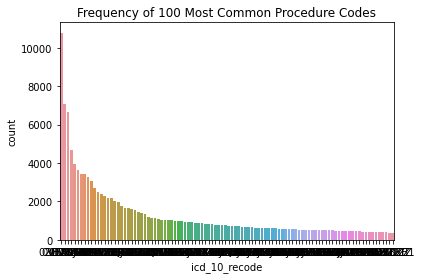

In [44]:
sns.countplot(x='icd_10_recode',data=proc_10_slim,order=proc_10_slim['icd_10_recode'].value_counts().iloc[:100].index).set(title='Frequency of 100 Most Common Procedure Codes');

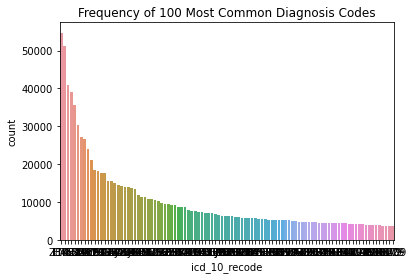

In [45]:
sns.countplot(x='icd_10_recode',data=diag_10_slim,order=diag_10_slim['icd_10_recode'].value_counts().iloc[:100].index).set(title='Frequency of 100 Most Common Diagnosis Codes');

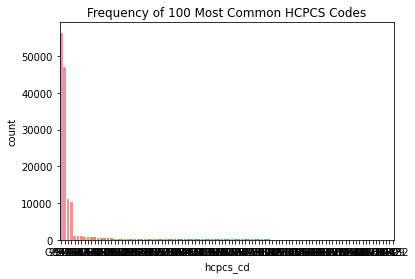

In [78]:
sns.countplot(x='hcpcs_cd',data=hcpcs_slim,order=hcpcs_slim['hcpcs_cd'].value_counts().iloc[:100].index).set(title='Frequency of 100 Most Common HCPCS Codes');

In [151]:
# create pivoted df's 
proc_10_slim = proc_10_slim.sort_values(by=['subject_id', 'hadm_id', 'seq_num'])
proc_10_pivot = proc_10_slim.groupby(['subject_id', 'hadm_id'], sort=False)['icd_10_recode'].apply(list).reset_index()
proc_10_pivot.columns = ['subject_id', 'hadm_id', 'proc_list']

diag_10_slim = diag_10_slim.sort_values(by=['subject_id', 'hadm_id', 'seq_num'])
diag_10_pivot = diag_10_slim.groupby(['subject_id', 'hadm_id'], sort=False)['icd_10_recode'].apply(list).reset_index()
diag_10_pivot.columns = ['subject_id', 'hadm_id', 'diag_list']

hcpcs_slim = hcpcs_slim.sort_values(by=['subject_id', 'hadm_id', 'seq_num'])
hcpcs_pivot = hcpcs_slim.groupby(['subject_id', 'hadm_id'], sort=False)['hcpcs_cd'].apply(list).reset_index()
hcpcs_pivot.columns = ['subject_id', 'hadm_id', 'hcpcs_list']
hcpcs_pivot.head()

,subject_id,hadm_id,hcpcs_list
0,10000068,25022803,[99218]
1,10000084,29888819,[G0378]
2,10000108,27250926,[99219]
3,10000117,22927623,"[43239, G0378]"
4,10000248,20600184,[99219]


In [ ]:
full_df = pat_df.merge(diag_10_pivot, on=['subject_id', 'hadm_id'])
full_df = full_df.merge(proc_10_pivot, on=['subject_id', 'hadm_id'])
full_df = full_df.merge(hcpcs_pivot, on=['subject_id', 'hadm_id'], how='left')
for row in full_df.loc[full_df.hcpcs_list.isnull(), 'hcpcs_list'].index:
    full_df.at[row, 'hcpcs_list'] = []

In [154]:
full_df['proc_list_length'] = full_df.apply(lambda x: len(x['proc_list']), axis=1)
full_df['diag_list_length'] = full_df.apply(lambda x: len(x['diag_list']), axis=1)
full_df['hcpcs_list_length'] = full_df.apply(lambda x: len(x['hcpcs_list']), axis=1)

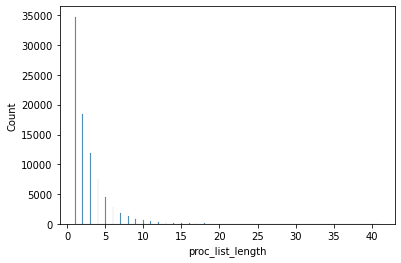

In [62]:
sns.histplot(x='proc_list_length', data=full_df);

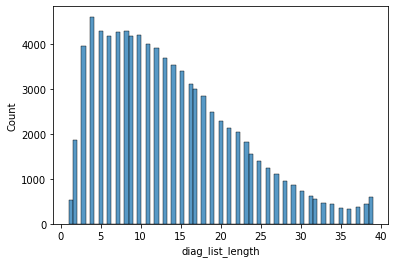

In [63]:
sns.histplot(x='diag_list_length', data=full_df);

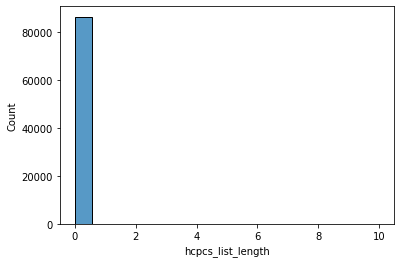

In [115]:
sns.histplot(x='hcpcs_list_length', data=full_df);

In [117]:
full_df[['diag_list_length', 'proc_list_length', 'hcpcs_list_length']].describe()

,diag_list_length,proc_list_length,hcpcs_list_length
count,86611.000000,86611.000000,86611.000000
mean,13.785420,2.815451,0.004895
std,8.471201,2.733763,0.115826
min,1.000000,1.000000,0.000000
25%,7.000000,1.000000,0.000000
50%,12.000000,2.000000,0.000000
75%,19.000000,3.000000,0.000000
max,39.000000,41.000000,10.000000


In [160]:
bins = [-1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
full_df['binned_age'] = pd.cut(full_df['age'], bins)

In [163]:
display(full_df.groupby('binned_age')['diag_list_length'].mean())
display(full_df.groupby('binned_age')['proc_list_length'].mean())

binned_age
(-1, 10]      5.318461
(10, 20]      7.505128
(20, 30]      8.991794
(30, 40]      9.943252
(40, 50]     12.322856
(50, 60]     14.420868
(60, 70]     15.779657
(70, 80]     17.565680
(80, 90]     18.426445
(90, 100]    18.475158
Name: diag_list_length, dtype: float64

binned_age
(-1, 10]     1.805721
(10, 20]     2.689744
(20, 30]     2.647150
(30, 40]     2.645683
(40, 50]     2.892473
(50, 60]     3.093470
(60, 70]     3.152626
(70, 80]     3.070971
(80, 90]     2.726247
(90, 100]    2.205962
Name: proc_list_length, dtype: float64

In [164]:
display(full_df.groupby('gender')['diag_list_length'].mean())
display(full_df.groupby('gender')['proc_list_length'].mean())

gender
F    13.696428
M    13.863910
Name: diag_list_length, dtype: float64

gender
F    2.773392
M    2.852546
Name: proc_list_length, dtype: float64